<a href="https://colab.research.google.com/github/Han-Daon/Project/blob/main/%EC%B5%9C%EC%B5%9C%EC%A2%85_MCLP_%EC%88%98%EC%A0%95_%EB%AA%A8%EB%8D%B8_(20%EB%8C%80).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-데이터-로드" data-toc-modified-id="1.-데이터-로드-1">1. 데이터 로드</a></span></li><li><span><a href="#2.-수요지점-좌표-리스트-생성" data-toc-modified-id="2.-수요지점-좌표-리스트-생성-2">2. 수요지점 좌표 리스트 생성</a></span></li><li><span><a href="#3.-MCLP-구현" data-toc-modified-id="3.-MCLP-구현-3">3. MCLP 구현</a></span></li></ul></div>

In [2]:
pip install haversine


In [3]:
pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 35.7 MB/s eta 0:00:00


In [4]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
import time
import pandas as pd
from itertools import zip_longest   # zip 함수 길이 다를 경우
from haversine import haversine

## 1. 데이터 로드

```
# 코드로 형식 지정됨
```



In [5]:
# 20대 입지 후보지는 전북 전체
입지후보지 = pd.read_csv('행정경계_중심.csv', encoding='cp949')
print(입지후보지.shape)
입지후보지.head(2)

(407, 6)


,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,x,y
0,45111101,45110,중앙동1가,1883,127.142278,35.816693
1,45111102,45110,중앙동2가,1884,127.143699,35.817163


- 행정기관, 도시공원, 영화관, 보건소는 수요지점 데이터로, isin 함수를 활용하여 **인근 행정동 데이터까지 포함**


- 기본적으로 전체 수요지점 데이터를 활용해도 되지만, 본 프로젝트의 수요지점은 개수가 많아 알고리즘이 제대로 동작하지 않으므로 부득이하게 **행정동별 수요지점 데이터를 따로 생성하여 저장**

In [6]:
행정기관 = pd.read_csv('행정기관_위도경도.csv', encoding='cp949')
#변수1 행정기관
print(행정기관.shape)
행정기관.head(2)

(243, 4)


,읍면동,주....소,V3,V4
0,중앙동주민센터,전라북도 전주시 완산구 태평3길 43-17,35.823637,127.140657
1,풍남동주민센터,전라북도 전주시 완산구 어진길 122-12,35.817064,127.148076


In [7]:
보건소 = pd.read_csv('보건소_위도경도.csv',encoding='cp949')
#변수2 보건소
print(보건소.shape)
보건소.head(2)

(407, 4)


,보건소명,도로명주소,V3,V4
0,전주시보건소,전주시 완산구 전라감영로 33,35.815362,127.142783
1,전주시평화보건지소,전주시 완산구 평화13길 7,35.790764,127.136666


In [8]:
영화관 = pd.read_csv('영화관_위도경도.csv', encoding='cp949')
#변수3 영화관
print(영화관.shape)
영화관.head(2)

(29, 4)


,영화상영관명,주소,V3,V4
0,CGV서전주,전라북도 전주시 완산구 홍산로 260 엠스퀘어 6층,35.816910,127.106455
1,메가박스 전주혁신,전라북도 전주시 덕진구 기지로 77 2층,35.839004,127.060137


In [9]:
도시공원 = pd.read_csv('전라북도 도시공원.csv',encoding='cp949')
#변수4 도시공원
print(도시공원.shape)
도시공원.head(2)

(674, 3)


,공원명,위도,경도
0,장계공원,35.727720,127.592399
1,의암공원,35.641115,127.518109


In [12]:
전국대학교 = pd.read_csv('대학교_위도경도.csv',encoding='cp949')
대학교=전국대학교[전국대학교['MEGA_NM'] == '전라북도']
#변수5 대학교
print(대학교.shape)
대학교.head(2)

(25, 4)


,MEGA_NM,SCHOOL_NM,x,y
36,전라북도,군산간호대학,126.760067,35.970871
73,전라북도,백제예술대학,127.127626,35.996778


In [13]:
 기관 = pd.read_csv('전북노후준비참여기관_위경도.csv',encoding='cp949')
#변수6 기관
print(기관.shape)
기관.head(2)

(71, 4)


,기관,주소,...3,...4
0,국민연금공단 전주완주지사,전북 전주시 완산구 온고을로 13,35.833351,127.121595
1,김제노인종합사회복지관,전북 김제시 하동1길 79,35.814823,126.894542


## 2. 수요지점 좌표 리스트 생성

In [15]:
후보지_points = np.array([list(i) for i in zip(입지후보지['y'], 입지후보지['x'])])

보건소_points = np.array([list(i) for i in zip(보건소['V3'], 보건소['V4'])])

영화관_points = np.array([list(i) for i in zip(영화관['V3'], 영화관['V4'])])

도시공원_points = np.array([list(i) for i in zip(도시공원['위도'], 도시공원['경도'])])

행정기관_points = np.array([list(i) for i in zip(행정기관['V3'], 행정기관['V4'])])

대학교_points = np.array([list(i) for i in zip(대학교['y'], 대학교['x'])])

기관_points = np.array([list(i) for i in zip(기관['...3'], 기관['...4'])])

In [ ]:
보건소_points = np.array([list(i) for i in zip(보건소['V3'], 보건소['V4'])])
print(보건소_points.shape)
보건소_points[:2]

(407, 2)


array([[ 35.8153618, 127.1427829],
       [ 35.7907639, 127.1366661]])

In [ ]:
영화관_points = np.array([list(i) for i in zip(영화관['V3'], 영화관['V4'])])
print(영화관_points.shape)
영화관_points[:2]

(29, 2)


array([[ 35.8169099, 127.106455 ],
       [ 35.839004 , 127.0601374]])

In [ ]:
도시공원_points = np.array([list(i) for i in zip(도시공원['위도'], 도시공원['경도'])])
print(도시공원_points.shape)
도시공원_points[:2]

(674, 2)


array([[ 35.72771983, 127.5923992 ],
       [ 35.6411154 , 127.5181094 ]])

In [ ]:
대학교_points = np.array([list(i) for i in zip(대학교['y'], 대학교['x'])])
print(대학교_points.shape)
대학교_points[:2]

(243, 2)


array([[ 35.823637 , 127.1406569],
       [ 35.8170644, 127.1480759]])

In [16]:
행정기관_points = np.array([list(i) for i in zip(행정기관['V3'], 행정기관['V4'])])
print(행정기관_points.shape)
행정기관_points[:2]

(243, 2)


array([[ 35.823637 , 127.1406569],
       [ 35.8170644, 127.1480759]])

In [17]:
기관_points = np.array([list(i) for i in zip(기관['...3'], 기관['...4'])])
print(기관_points.shape)
기관_points[:2]

(71, 2)


array([[ 35.8333513, 127.121595 ],
       [ 35.814823 , 126.8945421]])

In [21]:
X =  list(보건소['V4']) + list(영화관['V4']) + list(도시공원['경도']) + list(행정기관['V4']) + list(대학교['x']) + list(기관['...4'])
Y =  list(보건소['V3']) + list(영화관['V3']) + list(도시공원['위도']) + list(행정기관['V3']) + list(대학교['y']) + list(기관['...3'])
points = np.array([list(i) for i in zip(X, Y)])
print(points.shape)
points[:2]

(1449, 2)


array([[127.1427829,  35.8153618],
       [127.1366661,  35.7907639]])

In [22]:
X =  list(보건소['V4']) + list(영화관['V4']) + list(도시공원['경도']) + list(행정기관['V4']) + list(대학교['x']) + list(기관['...4'])
X[:2]

[127.1427829, 127.1366661]

In [23]:
Y =  list(보건소['V3']) + list(영화관['V3']) + list(도시공원['위도']) + list(행정기관['V3']) + list(대학교['y']) + list(기관['...3'])
Y[:2]

[35.8153618, 35.7907639]

In [24]:
points = np.array([list(i) for i in zip(X, Y)])
print(points.shape)
points[:2]

(1449, 2)


array([[127.1427829,  35.8153618],
       [127.1366661,  35.7907639]])

## 3. MCLP 구현

- 반경을 m 단위로 조절하기 위해 **haversine 라이브러리를 활용하여 거리 계산**


- 수요지점별 개수의 불균형 해소를 위해 가중치를 부여할 수 있도록 **목적함수 수정**

In [28]:
def mclp(보건소_points, 영화관_points, 도시공원_points, 행정기관_points, 기관_points, 대학교_points, points, K, radius):
    """
    Solve maximum covering location problem
    Input:
        points: 수요지점 좌표 (기타 인근에 있으면 좋은 시설 좌표)
        K: 배치할 홍보부스 수
        radius: 반경 (사람들이 이동하기 적합한 거리)
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(입지후보지['y'], 입지후보지['x'])])
    J = sites.shape[0]

    # 수요지점 수
    A = 보건소_points.shape[0]
    B = 영화관_points.shape[0]
    C = 도시공원_points.shape[0]
    D = 행정기관_points.shape[0]
    E = 대학교_points.shape[0]
    F = 기관_points.shape[0]


    # 입지후보지와 수요지점 간 거리 계산 (haversine으로 수정)
    D1 = []
    for i in 행정기관_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)     # 단위를 m로 변경하기 위해 *1000
        D1.append(site)
    D1 = np.array(D1)

    D2 = []
    for i in 영화관_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D2.append(site)
    D2 = np.array(D2)

    D3 = []
    for i in 도시공원_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D3.append(site)
    D3 = np.array(D3)

    D4 = []
    for i in 보건소_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D4.append(site)
    D4 = np.array(D4)

    D5 = []
    for i in 대학교_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D5.append(site)
    D5 = np.array(D5)


    D6 = []
    for i in 기관_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D6.append(site)
    D6 = np.array(D6)

    for i in [ D2, D3, D4, D5, D6]:
        mask1 = i<=radius
        i[mask1]=1
        i[~mask1]=0

    m = Model()
    x1, x2, x3, x4, x5, x6 = {}, {}, {}, {}, {}, {}
    y = {}

    # 수요지점 변수 추가
    #for i in range(A):
    #   x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
    for i in range(B):
        x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
    for i in range(C):
        x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
    for i in range(D):
        x4[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)
    for i in range(D):
        x5[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)
    for i in range(D):
        x6[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)

    # 입지후보지 변수 추가
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K)

    # 수요지점 제약 조건
   # for i in range(A):
    #    m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
    for i in range(B):
        m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
    for i in range(C):
        m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
    for i in range(D):
        m.addConstr(quicksum(y[j] for j in np.where(D4[i]==1)[0]) >= x4[i])
    for i in range(E):
        m.addConstr(quicksum(y[j] for j in np.where(D5[i]==1)[0]) >= x4[i])
    for i in range(F):
        m.addConstr(quicksum(y[j] for j in np.where(D6[i]==1)[0]) >= x4[i])


    # 목적함수 수정
    #m.setObjective(quicksum(i for i in  [0.953*x2[b] for b in range(B)] + [0.894*x3[c] for c in range(C)] + [0.929*x4[d] for d in range(D)]),\
     #              GRB.MAXIMIZE)
    # 수요지점별 개수의 불균형 해소를 위한 가중치 입력 ex) (전체수요지점 수 - 행정기관) / 전체수요지점 수

    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [33]:
opts_sites, mobjVal = mclp(보건소_points, 영화관_points, 도시공원_points, 행정기관_points, 기관_points, 대학교_points, points, 10, 1000)
opts_sites

  Number of points 1449
  K 10
  Radius 1000
----- Output -----
  Running time : 3.5633466243743896 seconds
  Optimal coverage points: 0


array([[ 35.76603513, 127.1321013 ],
       [ 35.76174883, 127.11176575],
       [ 35.7700201 , 127.07162376],
       [ 35.79626361, 127.08070179],
       [ 35.79273177, 127.17349974],
       [ 35.7949407 , 127.1962308 ],
       [ 35.81731058, 127.07533385],
       [ 35.81678409, 127.19849462],
       [ 35.89184421, 127.13800142],
       [ 35.89074653, 127.1233503 ]])

In [30]:
def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(2,2))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [31]:
def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(2,2)) #그래프 사이즈
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

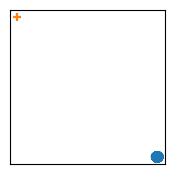

In [32]:
  plot_result(points, opts_sites, 0.005)